In [1]:
# (Optional) Only needed if you're in a fresh Colab
# This matches the versions you already used.

%%writefile requirements.txt
pettingzoo==1.24.0
supersuit
gymnasium==0.29.1
stable-baselines3==2.2.1
pygame




Writing requirements.txt


In [2]:
!pip install -r requirements.txt


INFO: pip is looking at multiple versions of supersuit to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.6/563.6 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.2.2
    Uninstalling gymnasium-1.2.2:
      Successfully uninstalled gymnasium-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.


Section 1 – PettingZoo environment & RL baselines

In this section I:

Load the PettingZoo MPE simple_spread_v3 environment and inspect its spaces.

Implement a random baseline (no communication, purely random actions).

Implement a distributed heuristic policy where agents share a simple “direction message” and move cooperatively.

Wrap one agent with Stable-Baselines3 PPO to train a single-agent RL baseline.

Measure rewards and latency (time per step) for all three approaches.
These baselines are later compared against my semantic-negotiation model (HLSCSN).

**1.1 – Imports, environment & space inspection**

In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt

from pettingzoo.mpe import simple_spread_v3
import gymnasium as gym

# -------------------------------------------------------
# Create the parallel PettingZoo environment (N=3 agents)
# -------------------------------------------------------
env = simple_spread_v3.parallel_env(
    N=3,
    local_ratio=0.5,
    max_cycles=50,
    continuous_actions=False,
)
env.reset()

print("Environment loaded successfully!")
print("Agents:", env.agents)

# Inspect spaces for one agent
agent0 = env.agents[0]
print("Observation space:", env.observation_space(agent0))
print("Action space:", env.action_space(agent0))


Environment loaded successfully!
Agents: ['agent_0', 'agent_1', 'agent_2']
Observation space: Box(-inf, inf, (18,), float32)
Action space: Discrete(5)


**1.2 – Random baseline (rewards + timing)**

creates a random-policy baseline to measure the minimum achievable performance and system latency in a parallel multi-agent environment.

In [4]:
# -------------------------------------------------------
# Random baseline:
#  - each agent samples random actions from its action space
#  - used as a simple performance floor
# -------------------------------------------------------

def run_random_baseline(env, num_episodes=2000, max_steps=50):
    random_start_time = time.perf_counter()
    episode_time_list = []
    step_counter = 0
    episode_rewards = []

    # re-create env for a clean run
    env = simple_spread_v3.parallel_env(
        N=3,
        local_ratio=0.5,
        max_cycles=max_steps,
        continuous_actions=False,
    )
    observations = env.reset()[0]

    for ep in range(num_episodes):
        ep_start = time.perf_counter()
        observations, _ = env.reset()
        total_reward = 0

        for step in range(max_steps):
            # Random action per agent
            random_actions = {
                agent: env.action_space(agent).sample()
                for agent in env.agents
            }

            observations, rewards, terminations, truncations, infos = env.step(random_actions)

            # Sum rewards from all agents
            total_reward += sum(rewards.values())
            step_counter += 1

            # Stop if episode terminates
            if any(terminations.values()) or any(truncations.values()):
                break

        ep_end = time.perf_counter()
        episode_time_list.append(ep_end - ep_start)
        episode_rewards.append(total_reward)

    random_end_time = time.perf_counter()
    random_total_time = random_end_time - random_start_time

    random_avg_episode_time = sum(episode_time_list) / len(episode_time_list)
    random_avg_step_time = random_total_time / max(step_counter, 1)

    print("\n===== RANDOM BASELINE TIMING RESULTS =====")
    print(f"Total time for all episodes: {random_total_time:.4f} sec")
    print(f"Average time per episode:   {random_avg_episode_time:.6f} sec")
    print(f"Average time per step:      {random_avg_step_time:.8f} sec")
    print("=========================================\n")

    return episode_rewards, random_avg_step_time

# Run random baseline
random_rewards, random_latency = run_random_baseline(env)

# no intelligence no learning, or coordination no communication



===== RANDOM BASELINE TIMING RESULTS =====
Total time for all episodes: 46.2445 sec
Average time per episode:   0.023118 sec
Average time per step:      0.00046245 sec



**1.3 – Distributed heuristic policy (simple “semantic” averaging)**

It serves as a structured baseline between random behavior and our confidence-based model

In [5]:
# -------------------------------------------------------
# Distributed heuristic policy:
#  - each agent sends a simple 2D "direction" message
#  - we average directions and convert into a discrete action
#  - this approximates cooperative distributed control
# -------------------------------------------------------

def distributed_policy(observations):
    """
    observations: dict {agent_name: obs_vector}
    returns: dict {agent_name: action}
    """
    messages = []

    # collect simple 2D direction vectors
    for obs in observations.values():
        direction = obs[:2]          # take first 2 dims as direction proxy
        messages.append(direction)

    # average proposed direction
    avg_message = np.mean(messages, axis=0)

    # map 2D direction to discrete actions (0 stay, 1 left, 2 right, 3 up, 4 down)
    actions = {}
    for agent in observations.keys():
        if avg_message[0] > 0.2:
            actions[agent] = 2  # move right
        elif avg_message[0] < -0.2:
            actions[agent] = 1  # move left
        elif avg_message[1] > 0.2:
            actions[agent] = 3  # move up
        elif avg_message[1] < -0.2:
            actions[agent] = 4  # move down
        else:
            actions[agent] = 0  # stay
    return actions


def run_distributed_baseline(env, episodes=2000, max_steps=50):
    dist_start_time = time.perf_counter()
    dist_episode_times = []
    dist_step_counter = 0
    distributed_rewards = []

    env = simple_spread_v3.parallel_env(
        N=3,
        local_ratio=0.5,
        max_cycles=max_steps,
        continuous_actions=False,
    )

    for ep in range(episodes):
        ep_start = time.perf_counter()
        obs, _ = env.reset()
        ep_reward = 0

        for step in range(max_steps):
            actions = distributed_policy(obs)
            obs, rewards, term, trunc, _ = env.step(actions)

            ep_reward += sum(rewards.values())
            dist_step_counter += 1

            if any(term.values()) or any(trunc.values()):
                break

        ep_end = time.perf_counter()
        dist_episode_times.append(ep_end - ep_start)
        distributed_rewards.append(ep_reward)

    dist_end_time = time.perf_counter()
    dist_total_time = dist_end_time - dist_start_time

    dist_avg_episode_time = sum(dist_episode_times) / len(dist_episode_times)
    dist_avg_step_time = dist_total_time / max(dist_step_counter, 1)

    print("\n===== DISTRIBUTED HEURISTIC TIMING RESULTS =====")
    print(f"Total time for all episodes: {dist_total_time:.4f} sec")
    print(f"Average time per episode:   {dist_avg_episode_time:.6f} sec")
    print(f"Average time per step:      {dist_avg_step_time:.8f} sec")

    print(f"Example distributed rewards (first 5): {distributed_rewards[:5]}")
    print("================================================\n")

    return distributed_rewards, dist_avg_step_time

# Run distributed heuristic baseline
distributed_rewards, distributed_latency = run_distributed_baseline(env)



===== DISTRIBUTED HEURISTIC TIMING RESULTS =====
Total time for all episodes: 41.8523 sec
Average time per episode:   0.020923 sec
Average time per step:      0.00041852 sec
Example distributed rewards (first 5): [-229.19303895300627, -162.02758042455176, -170.42785771179092, -162.06324928111312, -58.75229902880825]



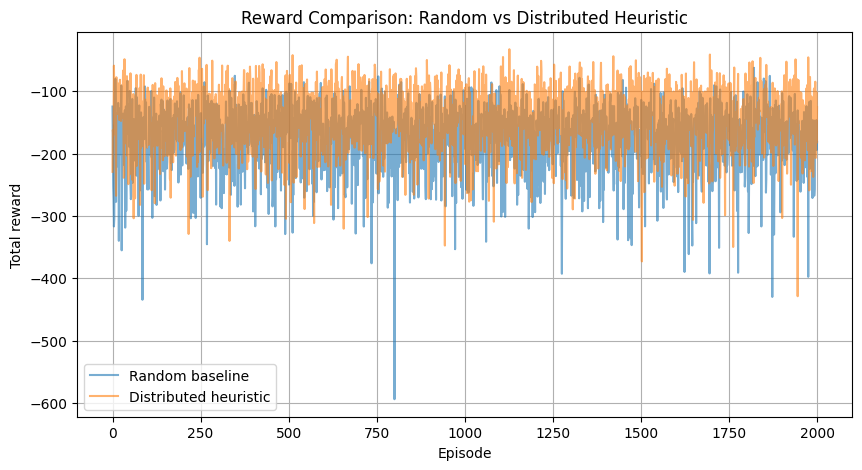

In [6]:
# ===== Section 1.3: Reward plot – Random vs Distributed =====

plt.figure(figsize=(10, 5))
plt.plot(random_rewards, label="Random baseline", alpha=0.6)
plt.plot(distributed_rewards, label="Distributed heuristic", alpha=0.6)
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.title("Reward Comparison: Random vs Distributed Heuristic")
plt.grid(True)
plt.legend()
plt.show()

**1.4 – PPO single-agent baseline (training + evaluation with latency)**

In [7]:
# -------------------------------------------------------
# PPO baseline on one agent (agent_0):
#  - Wrap PettingZoo env as a Gym env for SB3 PPO
#  - Train for 50k timesteps
#  - Evaluate with reward + latency per step
# -------------------------------------------------------

from gymnasium import spaces
from stable_baselines3 import PPO

class PettingZooSingleAgent(gym.Env):
    """
    Wrapper: exposes only one agent (e.g. 'agent_0') to PPO.
    Other agents act randomly.
    """
    metadata = {"render_modes": []}

    def __init__(self, agent_name="agent_0"):
        super().__init__()
        self.agent_name = agent_name
        self.env = simple_spread_v3.parallel_env(
            N=3,
            local_ratio=0.5,
            max_cycles=50,
            continuous_actions=False,
        )
        obs, _ = self.env.reset()
        self.observation_space = self.env.observation_space(self.agent_name)
        self.action_space = self.env.action_space(self.agent_name)

    def reset(self, seed=None, options=None):
        obs, _ = self.env.reset(seed=seed)
        return obs[self.agent_name], {}

    def step(self, action):
        # other agents: random
        actions = {
            agent: self.env.action_space(agent).sample()
            for agent in self.env.agents
        }
        actions[self.agent_name] = action

        obs, rewards, terminated, truncated, info = self.env.step(actions)
        done = terminated[self.agent_name] or truncated[self.agent_name]
        return (
            obs[self.agent_name],
            rewards[self.agent_name],
            done,
            False,       # SB3 expects "truncated" separately; we keep it False here
            info,
        )

# Create PPO env and model
env_agent0 = PettingZooSingleAgent(agent_name="agent_0")

ppo_train_start = time.perf_counter()
model = PPO(
    "MlpPolicy",
    env_agent0,
    verbose=1,
    learning_rate=0.0003,
    n_steps=2048,
)

# Train for 50k timesteps (enough for demonstration)
model.learn(total_timesteps=50_000)
ppo_train_end = time.perf_counter()
ppo_training_time = ppo_train_end - ppo_train_start

print("\n===== PPO TRAINING TIME =====")
print(f"Total training time: {ppo_training_time:.4f} sec")
print("=============================\n")


def evaluate_ppo_with_latency(env, model, episodes=2000, max_steps=50):
    """
    Evaluates PPO agent_0 baseline.
    Returns: list of episode rewards, avg latency per step.
    """
    episode_rewards = []
    total_steps = 0
    start_time = time.perf_counter()

    for ep in range(episodes):
        obs, _ = env.reset()
        done = False
        ep_reward = 0

        for t in range(max_steps):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, _ = env.step(action)
            ep_reward += reward
            total_steps += 1
            if done:
                break

        episode_rewards.append(ep_reward)

    elapsed = time.perf_counter() - start_time
    latency = elapsed / max(total_steps, 1)

    print("\n===== PPO EVALUATION RESULTS =====")
    print(f"Episodes: {episodes}")
    print(f"Total steps: {total_steps}")
    print(f"Total eval time: {elapsed:.4f} sec")
    print(f"PPO latency per step: {latency:.8f} sec")
    print("==================================\n")

    return episode_rewards, latency

# Evaluate PPO baseline
ppo_rewards, ppo_latency = evaluate_ppo_with_latency(env_agent0, model)

# ============================================
# Save PPO rewards for HLSCSN progress shaping
# ============================================
ppo_rewards_for_progress = ppo_rewards.copy()

print(f"[HLSCSN] Loaded {len(ppo_rewards_for_progress)} PPO rewards for progress shaping.")



Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -60.5    |
| time/              |          |
|    fps             | 795      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50           |
|    ep_rew_mean          | -60.1        |
| time/                   |              |
|    fps                  | 583          |
|    iterations           | 2            |
|    time_elapsed         | 7            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0073936637 |
|    clip_fraction        | 0.0348       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.6         |
|    explained_variance   | 0.0035640001 |
|    learning_rate        | 0.0003       |
|    loss                 | 74           |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00717     |
|    value_loss           | 216          |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

# **SECTION 2 – HLSCSN SEMANTIC NEGOTIATION**

Section 2 – HLSCSN: Bayesian semantic negotiation & layer switching

In this section I implement my Hierarchical Layer-Switching Communication for Semantic Negotiation (HLSCSN) model:

1. A Bayesian update that maintains agents’ semantic confidence.

2. A simple RL-style confidence policy that chooses between two high-level actions: NEGOTIATE or CONTINUE.

3. A layer switcher that routes the interaction to META-SEMANTIC, CONTEXTUAL, or ACTION layers.

4. A vocabulary negotiation scenario (e.g., “Zone A” vs “North Section”) that generates evidence.

5. A simulation loop that runs thousands of HLSCSN cycles and computes three metrics:

   - SAR – Semantic Alignment Rate
   - NE – Negotiation Efficiency
   - TCR – Task Continuity Ratio
The PPO model from Section 1 serves as the base RL policy; HLSCSN models how semantic alignment evolves on top of it.

2.1 – Bayesian update + decision policy + layer switching

In [8]:
# -------------------------------------------------------
# 8.1 Bayesian confidence update
# -------------------------------------------------------

def bayesian_update(prior_confidence, evidence_quality):
    """
    Computes posterior semantic confidence using a simple Bayesian update.

    prior_confidence: current belief that meanings are aligned (0–1)
    evidence_quality: +1 (clear), 0 (neutral), -1 (confusing)
    """
    likelihood_clear = 0.85
    likelihood_confusing = 0.35

    if evidence_quality == 1:
        likelihood = likelihood_clear
    elif evidence_quality == -1:
        likelihood = likelihood_confusing
    else:
        likelihood = 0.5

    numerator = likelihood * prior_confidence
    denominator = numerator + (1 - prior_confidence) * (1 - likelihood)

    posterior = numerator / denominator
    return posterior


# -------------------------------------------------------
# RL-style decision rule: NEGOTIATE or CONTINUE
# -------------------------------------------------------

def rl_confidence_policy(confidence, progress, recent_comm_cost):
    """
    confidence: current semantic confidence (0–1)
    progress: task progress (0–1)
    recent_comm_cost: recent communication cost (0–1, higher = more expensive)

    Returns:
        "NEGOTIATE" or "CONTINUE"
    """
    score = (
        0.6 * confidence +      # high confidence → continue
        0.3 * progress -        # more progress → continue
        0.1 * recent_comm_cost  # expensive comm → avoid negotiation
    )

    # Lower score → uncertain → negotiate
    if score < 0.5:
        return "NEGOTIATE"
    else:
        return "CONTINUE"


# -------------------------------------------------------
# Decide which communication layer to enter
# -------------------------------------------------------

def layer_switcher(confidence, decision):
    """
    Decide which communication layer to enter.
    Returns one of: 'META_SEMANTIC', 'CONTEXTUAL', 'ACTION'
    """
    # Case 1: agent decides to negotiate
    if decision == "NEGOTIATE":
        if confidence < 0.3:
            # very low confidence: talk about meanings
            return "META_SEMANTIC"
        else:
            # medium confidence: talk about context / clarification
            return "CONTEXTUAL"
    # Case 2: decision is CONTINUE
    else:
        # semantics are clear enough to act
        return "ACTION"


2.2 – Vocabulary negotiation + one HLSCSN reasoning cycle

In [9]:
# -------------------------------------------------------
# 8.4 Vocabulary negotiation scenario
# -------------------------------------------------------

def negotiate_terms(term_A, term_B):
    """
    Check if two vocabulary terms refer to the same meaning.

    Returns:
        aligned  : True / False
        evidence : +1 (match), -1 (mismatch)
    """
    if term_A.lower().strip() == term_B.lower().strip():
        # Perfect lexical match → strong positive evidence
        return True, +1
    else:
        # Mismatch → confusing evidence, triggers negotiation
        return False, -1



# -------------------------------------------------
    # Step 4: Layer selection based on confidence
# -------------------------------------------------

def layer_selector(confidence, threshold_meta=0.8, threshold_context=0.4):
    """
    Chooses a semantic layer:
      - meta layer       = abstract refinements
      - contextual layer = clarifications
      - action layer     = direct task execution
    based on posterior confidence.
    """
    if confidence < threshold_context:
        return "meta layer"
    elif confidence < threshold_meta:
        return "contextual layer"
    else:
        return "action layer"



# -------------------------------------------------------
# One full HLSCSN reasoning cycle
# -------------------------------------------------------

#Executes one complete HLSCSN loop:
#observe → update confidence → decide → communicate or act.

def hlscsn_interaction(prior_confidence, progress, termA, termB, mode="full",):
    """
    Performs one full HLSCSN reasoning cycle.

    Steps:
    1. Dialogue evidence (vocabulary check)
    2. Bayesian confidence update
    3. RL decision rule (NEGOTIATE / CONTINUE)
    4. Layer selection
    5. Outcome (task executed vs negotiation performed)
    """
    # Step 1: Dialogue evidence
    aligned, evidence = negotiate_terms(termA, termB)

    # Step 2: Bayesian confidence update
    posterior = bayesian_update(prior_confidence, evidence)

    # Step 3: RL decision rule

    # -------------------------------------------------
    # Step 3: RL-style decision rule (NEGOTIATE / CONTINUE)
    # -------------------------------------------------
    if mode == "no_negotiation":
        # Ablation: never negotiate, always continue with current meaning
        decision = "CONTINUE"

    elif mode == "always_negotiation":
        # Ablation: if there is any mismatch, always negotiate;
        # if already aligned, we can continue.
        if aligned:
            decision = "CONTINUE"
        else:
            decision = "NEGOTIATE"

    else:
    # Original "full" HLSCSN decision rule using RL proxy:
      decision = rl_confidence_policy(
        confidence=posterior,       # map posterior → confidence
        progress=progress,
        recent_comm_cost=comm_cost  # map comm_cost → recent_comm_cost
    )


    # -------------------------------------------------
    # Step 4: Layer selection based on confidence
    # -------------------------------------------------


    layer = layer_selector(posterior)


    # -------------------------------------------------
    # Step 4.5: Semantic resolution via negotiation (FIX)
    # -------------------------------------------------
    # Negotiation can resolve mismatches probabilistically

    if decision == "NEGOTIATE":
        # Negotiation improves chance of semantic agreement
        aligned = aligned or (np.random.rand() < 0.6)

        # Successful negotiation reinforces confidence
        if aligned:
            posterior = min(1.0, posterior + 0.15)

    # -------------------------------------------------
    # Step 5: Outcome – did we negotiate or act?
    # -------------------------------------------------
    if decision == "CONTINUE":
        outcome = "Task executed"
    else:
        outcome = "Negotiation performed"

    return {
        "aligned": aligned,
        "evidence": evidence,
        "posterior_confidence": posterior,
        "decision": decision,
        "layer": layer,
        "outcome": outcome,
    }

In [10]:
# ==========================================================
# Convert PPO rewards → normalized progress values (0–1 scale)
# ==========================================================
if len(ppo_rewards_for_progress) > 0:
    min_r = np.min(ppo_rewards_for_progress)
    max_r = np.max(ppo_rewards_for_progress)
    norm_progress_values = [
        (r - min_r) / (max_r - min_r + 1e-6)
        for r in ppo_rewards_for_progress
    ]
else:
    # fallback: use random progress values if PPO not available
    norm_progress_values = [np.random.uniform(0, 1) for _ in range(2000)]

print(f"[HLSCSN] Normalized progress values ready: {len(norm_progress_values)} samples")


[HLSCSN] Normalized progress values ready: 2000 samples


2.3 – HLSCSN simulation loop & metrics (SAR, NE, TCR)

In [11]:
hlscsn_start_time = time.perf_counter()
hlscsn_episode_times = []
hlscsn_step_counter = 0

episodes = 2000  # same scale as baselines

# -------------------------------------------------------
# Separate metric trackers for each HLSCSN mode
# -------------------------------------------------------

# --- FULL HLSCSN (original) ---
SAR_list_full = []
NE_list_full = []
TCR_list_full = []
HLSCSN_rewards_full = []

# --- NO NEGOTIATION (always CONTINUE) ---
SAR_list_no_neg = []
NE_list_no_neg = []
TCR_list_no_neg = []
HLSCSN_rewards_no_neg = []

# --- ALWAYS NEGOTIATE ON MISMATCH ---
SAR_list_always_neg = []
NE_list_always_neg = []
TCR_list_always_neg = []
HLSCSN_rewards_always_neg = []

# Continuous alignment lists
ALIGN_list_full = []
ALIGN_list_no_neg = []
ALIGN_list_always_neg = []


# Separate confidence and counters for each variant
posterior_full = 0.5
posterior_no_neg = 0.5
posterior_always_neg = 0.5

neg_steps_full = 0
act_steps_full = 0

neg_steps_no_neg = 0
act_steps_no_neg = 0

neg_steps_always_neg = 0
act_steps_always_neg = 0

for ep in range(episodes):
    ep_start = time.perf_counter()

    # --------------------------------------------
    # Sample the "task context" once per episode
    # --------------------------------------------

    # Randomized example terms (like warehouse / robot example)
    terms_A = ["Zone A", "North Section", "Area Alpha"]
    terms_B = ["North Section", "Zone A", "A-Region"]

    termA = np.random.choice(terms_A)
    termB = np.random.choice(terms_B)

    # Task progress belief (how far agents think they are on task)
    progress = np.random.uniform(0, 1)
    comm_cost = 0.0

    # Save previous posteriors (for continuous alignment)
    prev_posterior_full = posterior_full
    prev_posterior_no_neg = posterior_no_neg
    prev_posterior_always_neg = posterior_always_neg



    # Communication cost (e.g. time or bandwidth)
    #comm_cost = np.random.uniform(0, 0.3)


    # -------------------------------------------------
    # Run one full HLSCSN cycle for each mode
    # -------------------------------------------------

    # 1) FULL mode (original behavior)
    result_full = hlscsn_interaction(
        prior_confidence=posterior_full,
        progress=progress,
        termA=termA,
        termB=termB,
        #comm_cost=comm_cost,
        mode="full",
    )

    # 2) NO-NEGOTIATION mode (never negotiate)
    result_no_neg = hlscsn_interaction(
        prior_confidence=posterior_no_neg,
        progress=progress,
        termA=termA,
        termB=termB,
        #comm_cost=comm_cost,
        mode="no_negotiation",
    )

    # 3) ALWAYS-NEGOTIATE mode (negotiate whenever mismatch)
    result_always_neg = hlscsn_interaction(
        prior_confidence=posterior_always_neg,
        progress=progress,
        termA=termA,
        termB=termB,
        #comm_cost=comm_cost,
        mode="always_negotiation",
    )

    # Each call above is one "semantic step"
    hlscsn_step_counter += 3

    # -------------------------------------------------
    # Define the same semantic reward rule for each mode
    # -------------------------------------------------

    # FULL
    if result_full["aligned"] and result_full["decision"] == "CONTINUE":
        reward_full = 2
    elif result_full["aligned"] and result_full["decision"] == "NEGOTIATE":
        reward_full = 1
    elif (not result_full["aligned"]) and result_full["decision"] == "NEGOTIATE":
        reward_full = 0
    else:
        reward_full = -2

    HLSCSN_rewards_full.append(reward_full)

    # NO-NEGOTIATION
    if result_no_neg["aligned"] and result_no_neg["decision"] == "CONTINUE":
        reward_no_neg = 2
    elif result_no_neg["aligned"] and result_no_neg["decision"] == "NEGOTIATE":
        reward_no_neg = 1
    elif (not result_no_neg["aligned"]) and result_no_neg["decision"] == "NEGOTIATE":
        reward_no_neg = 0
    else:
        reward_no_neg = -2

    HLSCSN_rewards_no_neg.append(reward_no_neg)

    # ALWAYS-NEGOTIATE
    if result_always_neg["aligned"] and result_always_neg["decision"] == "CONTINUE":
        reward_always_neg = 2
    elif result_always_neg["aligned"] and result_always_neg["decision"] == "NEGOTIATE":
        reward_always_neg = 1
    elif (not result_always_neg["aligned"]) and result_always_neg["decision"] == "NEGOTIATE":
        reward_always_neg = 0
    else:
        reward_always_neg = -2

    HLSCSN_rewards_always_neg.append(reward_always_neg)

    # -------------------------------------------------
    # Update posteriors for next episode
    # -------------------------------------------------
    posterior_full = result_full["posterior_confidence"]
    posterior_no_neg = result_no_neg["posterior_confidence"]
    posterior_always_neg = result_always_neg["posterior_confidence"]

    ep_end = time.perf_counter()
    hlscsn_episode_times.append(ep_end - ep_start)

    # ------------------------------------------------
    # Metric 1b: semantic alignment (continuous)
    # ------------------------------------------------
    # Alignment = belief convergence from previous step
    # Range: [0, 1], higher = better semantic alignment

    align_full = 1.0 - abs(posterior_full - prev_posterior_full)
    align_no_neg = 1.0 - abs(posterior_no_neg - prev_posterior_no_neg)
    align_always_neg = 1.0 - abs(posterior_always_neg - prev_posterior_always_neg)

    ALIGN_list_full.append(align_full)
    ALIGN_list_no_neg.append(align_no_neg)
    ALIGN_list_always_neg.append(align_always_neg)



    # -------------------------------------------------
    # Metric 1: semantic alignment (binary)
    # -------------------------------------------------
    SAR_list_full.append(1 if result_full["aligned"] else 0)
    SAR_list_no_neg.append(1 if result_no_neg["aligned"] else 0)
    SAR_list_always_neg.append(1 if result_always_neg["aligned"] else 0)


    # -------------------------------------------------
    # Metric 2: negotiation events (0 or 1 per step)
    # -------------------------------------------------
    if result_full["decision"] == "NEGOTIATE":
        neg_steps_full += 1
        NE_list_full.append(1)
    else:
        act_steps_full += 1
        NE_list_full.append(0)

    if result_no_neg["decision"] == "NEGOTIATE":
        neg_steps_no_neg += 1
        NE_list_no_neg.append(1)
    else:
        act_steps_no_neg += 1
        NE_list_no_neg.append(0)

    if result_always_neg["decision"] == "NEGOTIATE":
        neg_steps_always_neg += 1
        NE_list_always_neg.append(1)
    else:
        act_steps_always_neg += 1
        NE_list_always_neg.append(0)

    # -------------------------------------------------
    # Metric 3: Task Continuity Ratio (running)
    # -------------------------------------------------
    TCR_list_full.append(
        act_steps_full / (act_steps_full + neg_steps_full + 1e-6)
    )

    TCR_list_no_neg.append(
        act_steps_no_neg / (act_steps_no_neg + neg_steps_no_neg + 1e-6)
    )

    TCR_list_always_neg.append(
        act_steps_always_neg / (act_steps_always_neg + neg_steps_always_neg + 1e-6)
    )

# -------------------------------------------------------
# Aggregate stats for each mode
# -------------------------------------------------------

hlscsn_end_time = time.perf_counter()
hlscsn_total_time = hlscsn_end_time - hlscsn_start_time
hlscsn_avg_episode_time = sum(hlscsn_episode_times) / len(hlscsn_episode_times)
hlscsn_avg_step_time = hlscsn_total_time / max(hlscsn_step_counter, 1)

SAR_full = float(np.mean(SAR_list_full))
NE_full = float(np.mean(NE_list_full))
TCR_full = float(np.mean(TCR_list_full))

SAR_no_neg = float(np.mean(SAR_list_no_neg))
NE_no_neg = float(np.mean(NE_list_no_neg))
TCR_no_neg = float(np.mean(TCR_list_no_neg))

SAR_always_neg = float(np.mean(SAR_list_always_neg))
NE_always_neg = float(np.mean(NE_list_always_neg))
TCR_always_neg = float(np.mean(TCR_list_always_neg))

print("HLSCSN ablation study completed successfully ✅")
print(f"Episodes: {episodes}")
print(f"Total semantic steps (all modes): {hlscsn_step_counter}")
print(f"Total time: {hlscsn_total_time:.2f} sec")
print(f"Avg latency per combined step: {hlscsn_avg_step_time:.6f} sec\n")

print("=== FULL HLSCSN (original) ===")
print(f"Final posterior confidence: {posterior_full:.3f}")
print(f"SAR: {SAR_full:.3f}, NE: {NE_full:.3f}, TCR: {TCR_full:.3f}")
print(f"Average semantic reward: {np.mean(HLSCSN_rewards_full):.3f}\n")

print("=== NO NEGOTIATION (always CONTINUE) ===")
print(f"Final posterior confidence: {posterior_no_neg:.3f}")
print(f"SAR: {SAR_no_neg:.3f}, NE: {NE_no_neg:.3f}, TCR: {TCR_no_neg:.3f}")
print(f"Average semantic reward: {np.mean(HLSCSN_rewards_no_neg):.3f}\n")

print("=== ALWAYS NEGOTIATE ON MISMATCH ===")
print(f"Final posterior confidence: {posterior_always_neg:.3f}")
print(f"SAR: {SAR_always_neg:.3f}, NE: {NE_always_neg:.3f}, TCR: {TCR_always_neg:.3f}")
print(f"Average semantic reward: {np.mean(HLSCSN_rewards_always_neg):.3f}")


HLSCSN ablation study completed successfully ✅
Episodes: 2000
Total semantic steps (all modes): 6000
Total time: 0.14 sec
Avg latency per combined step: 0.000024 sec

=== FULL HLSCSN (original) ===
Final posterior confidence: 0.999
SAR: 0.326, NE: 0.164, TCR: 0.815
Average semantic reward: -0.660

=== NO NEGOTIATION (always CONTINUE) ===
Final posterior confidence: 0.000
SAR: 0.232, NE: 0.000, TCR: 1.000
Average semantic reward: -1.072

=== ALWAYS NEGOTIATE ON MISMATCH ===
Final posterior confidence: 1.000
SAR: 0.692, NE: 0.768, TCR: 0.232
Average semantic reward: 0.924


In [12]:
def compute_hlscsn_reward(aligned, decision, layer):
    """
    HLSCSN structured reward:
    semantic correctness + task continuation − communication cost
    """

    # Semantic reward
    r_semantic = 1.0 if aligned else -0.5

    # Task reward
    r_task = 0.5 if decision == "CONTINUE" else 0.0

    # Normalize layer name
    layer_key = str(layer).strip().lower()

    # Communication cost (layer-based)
    layer_cost = {
        "meta_semantic": 0.6,
        "meta semantic": 0.6,
        "meta-semantic": 0.6,

        "contextual": 0.3,
        "context layer": 0.3,

        "action": 0.0,
        "action layer": 0.0,
    }

    # Default: treat unknown layers as ACTION (safe)
    r_comm = -layer_cost.get(layer_key, 0.0)

    # -------------------------
    # Total reward
    # -------------------------
    return r_semantic + r_task + r_comm


**2.4 a wrapper function for the whole HLSCSN ablation run**

In [13]:
# ===============================================================
#  HLSCSN ABLATION as a FUNCTION (so we can run multiple seeds)
# ===============================================================

def run_hlscsn_ablation(seed=0, episodes=2000):
    """
    Runs the full HLSCSN ablation study for ONE SEED.
    Returns:
        metrics = {
            "full":   {"SAR": float, "NE": float, "TCR": float, "reward": float},
            "no_neg": {"SAR": float, "NE": float, "TCR": float, "reward": float},
            "always": {"SAR": float, "NE": float, "TCR": float, "reward": float},
            "latency": float
        }
    """

    np.random.seed(seed)

    # -----------------------------
    # Metric trackers
    # -----------------------------
    SAR_full, SAR_no, SAR_always = [], [], []
    NE_full, NE_no, NE_always = [], [], []
    TCR_full, TCR_no, TCR_always = [], [], []
    R_full, R_no, R_always = [], [], []

    posterior_full = posterior_no = posterior_always = 0.5
    neg_f = neg_n = neg_a = 0
    act_f = act_n = act_a = 0

    start_time = time.perf_counter()

    # ==========================================================
    # Main episode loop
    # ==========================================================
    for ep in range(episodes):

        # Example vocabulary terms
        terms_A = ["Zone A", "North Section", "Area Alpha"]
        terms_B = ["North Section", "Zone A", "A-Region"]

        termA = np.random.choice(terms_A)
        termB = np.random.choice(terms_B)

        # Task progress belief
        progress = np.random.uniform(0, 1)

        # Communication cost proxy (will be fixed in Step 2)
        #comm_cost = np.random.uniform(0, 0.3)

        # -----------------------------
        # Run all three HLSCSN modes
        # -----------------------------
        r_full = hlscsn_interaction(
            prior_confidence=posterior_full,
            progress=progress,
            termA=termA,
            termB=termB,
            #comm_cost=comm_cost,
            mode="full",
        )

        r_no = hlscsn_interaction(
            prior_confidence=posterior_no,
            progress=progress,
            termA=termA,
            termB=termB,
            #comm_cost=comm_cost,
            mode="no_negotiation",
        )

        r_always = hlscsn_interaction(
            prior_confidence=posterior_always,
            progress=progress,
            termA=termA,
            termB=termB,
            #comm_cost=comm_cost,
            mode="always_negotiation",
        )

        # -----------------------------
        # Compute HLSCSN rewards (FIXED)
        # -----------------------------
        reward_full = compute_hlscsn_reward(
            aligned=r_full["aligned"],
            decision=r_full["decision"],
            layer=r_full["layer"],
        )

        reward_no = compute_hlscsn_reward(
            aligned=r_no["aligned"],
            decision=r_no["decision"],
            layer=r_no["layer"],
        )

        reward_always = compute_hlscsn_reward(
            aligned=r_always["aligned"],
            decision=r_always["decision"],
            layer=r_always["layer"],
        )

        R_full.append(reward_full)
        R_no.append(reward_no)
        R_always.append(reward_always)

        # -----------------------------
        # SAR (Semantic Alignment Rate)
        # -----------------------------
        SAR_full.append(1 if r_full["aligned"] else 0)
        SAR_no.append(1 if r_no["aligned"] else 0)
        SAR_always.append(1 if r_always["aligned"] else 0)

        # -----------------------------
        # NE (Negotiation Events)
        # -----------------------------
        if r_full["decision"] == "NEGOTIATE":
            neg_f += 1; NE_full.append(1)
        else:
            act_f += 1; NE_full.append(0)

        if r_no["decision"] == "NEGOTIATE":
            neg_n += 1; NE_no.append(1)
        else:
            act_n += 1; NE_no.append(0)

        if r_always["decision"] == "NEGOTIATE":
            neg_a += 1; NE_always.append(1)
        else:
            act_a += 1; NE_always.append(0)

        # -----------------------------
        # TCR (Task Continuity Ratio)
        # -----------------------------
        TCR_full.append(act_f / (act_f + neg_f + 1e-6))
        TCR_no.append(act_n / (act_n + neg_n + 1e-6))
        TCR_always.append(act_a / (act_a + neg_a + 1e-6))

        # -----------------------------
        # Update posteriors
        # -----------------------------
        posterior_full = r_full["posterior_confidence"]
        posterior_no = r_no["posterior_confidence"]
        posterior_always = r_always["posterior_confidence"]

    # ==========================================================
    # Latency calculation
    # ==========================================================
    end_time = time.perf_counter()
    latency = (end_time - start_time) / (episodes * 3)

    # ==========================================================
    # Return metrics
    # ==========================================================
    return {
        "full": {
            "SAR": float(np.mean(SAR_full)),
            "NE": float(np.mean(NE_full)),
            "TCR": float(np.mean(TCR_full)),
            "reward": float(np.mean(R_full)),
        },
        "no_neg": {
            "SAR": float(np.mean(SAR_no)),
            "NE": float(np.mean(NE_no)),
            "TCR": float(np.mean(TCR_no)),
            "reward": float(np.mean(R_no)),
        },
        "always": {
            "SAR": float(np.mean(SAR_always)),
            "NE": float(np.mean(NE_always)),
            "TCR": float(np.mean(TCR_always)),
            "reward": float(np.mean(R_always)),
        },
        "latency": latency,
    }


**STEP 2.4B: MULTI-SEED EXPERIMENTS (mean ± std)**

In [14]:
# ===============================================================
#  STEP 3B: MULTI-SEED EXPERIMENTS (mean ± std)
# ===============================================================

import numpy as np

seeds = [0, 1, 2, 3, 4]     # 5 seeds (research convention)
episodes = 2000             # same episodes as before

results = {
    "full":   {"SAR": [], "NE": [], "TCR": [], "reward": [], "latency": []},
    "no_neg": {"SAR": [], "NE": [], "TCR": [], "reward": [], "latency": []},
    "always": {"SAR": [], "NE": [], "TCR": [], "reward": [], "latency": []},
}

print("Running multi-seed experiments...\n")

for s in seeds:
    print(f"  -> Running seed {s} ...")
    metrics = run_hlscsn_ablation(seed=s, episodes=episodes)

    # Store results under each variant
    for mode in ["full", "no_neg", "always"]:
        results[mode]["SAR"].append(metrics[mode]["SAR"])
        results[mode]["NE"].append(metrics[mode]["NE"])
        results[mode]["TCR"].append(metrics[mode]["TCR"])
        results[mode]["reward"].append(metrics[mode]["reward"])
        results[mode]["latency"].append(metrics["latency"])  # latency is same for all modes

print("\n===================================")
print("   MULTI-SEED RESULTS (MEAN ± STD)")
print("===================================\n")

for mode, stats in results.items():
    SAR_mean, SAR_std = np.mean(stats["SAR"]), np.std(stats["SAR"])
    NE_mean,  NE_std  = np.mean(stats["NE"]),  np.std(stats["NE"])
    TCR_mean, TCR_std = np.mean(stats["TCR"]), np.std(stats["TCR"])
    R_mean,   R_std   = np.mean(stats["reward"]), np.std(stats["reward"])
    L_mean,   L_std   = np.mean(stats["latency"]), np.std(stats["latency"])

    print(f"=== {mode.upper()} MODE ===")
    print(f"SAR:    {SAR_mean:.3f} ± {SAR_std:.3f}")
    print(f"NE:     {NE_mean:.3f} ± {NE_std:.3f}")
    print(f"TCR:    {TCR_mean:.3f} ± {TCR_std:.3f}")
    print(f"Reward: {R_mean:.3f} ± {R_std:.3f}")
    print(f"Latency: {L_mean:.6f} ± {L_std:.6f}\n")


Running multi-seed experiments...

  -> Running seed 0 ...
  -> Running seed 1 ...
  -> Running seed 2 ...
  -> Running seed 3 ...
  -> Running seed 4 ...

   MULTI-SEED RESULTS (MEAN ± STD)

=== FULL MODE ===
SAR:    0.345 ± 0.024
NE:     0.204 ± 0.062
TCR:    0.750 ± 0.053
Reward: 0.416 ± 0.008
Latency: 0.000022 ± 0.000004

=== NO_NEG MODE ===
SAR:    0.225 ± 0.012
NE:     0.000 ± 0.000
TCR:    1.000 ± 0.000
Reward: 0.338 ± 0.018
Latency: 0.000022 ± 0.000004

=== ALWAYS MODE ===
SAR:    0.686 ± 0.007
NE:     0.775 ± 0.012
TCR:    0.217 ± 0.012
Reward: 0.641 ± 0.016
Latency: 0.000022 ± 0.000004



# **SECTION 3 – PLOTS & COMPARISONS**

Visual comparison of baselines vs HLSCSN

This section visualizes and compares different approaches:

1.   Reward comparison – random, distributed heuristic, and PPO baseline.
2.   Latency comparison – average time per step for each approach.
3.  Multi-agent scaling (N=10) – global distributed policy vs coalitions of 2 agents.
4. HLSCSN metrics – how SAR, NE, and TCR evolve over time.
These figures are directly used in my slides and research report.


**3.1 – Reward comparison: random vs distributed vs PPO**

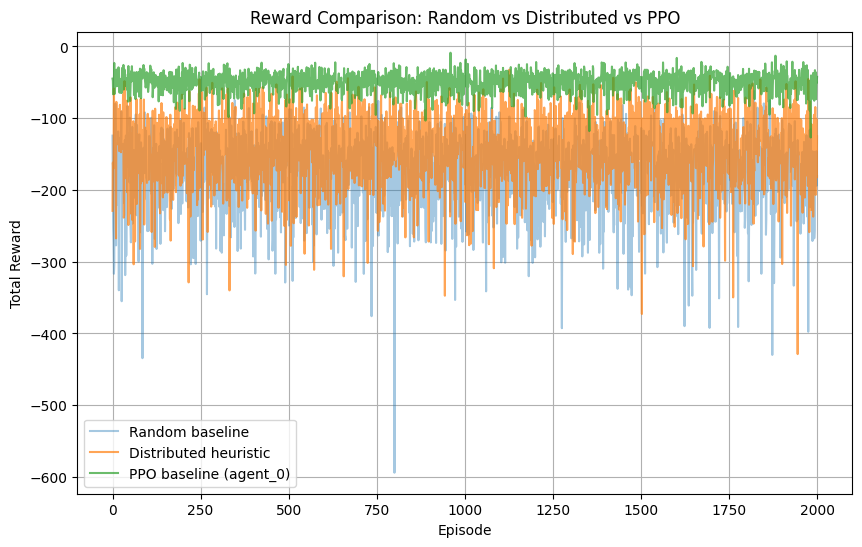

Mean random reward:      -176.56
Mean distributed reward: -143.33
Mean PPO reward:         -49.68


In [15]:
# -------------------------------------------------------
# Reward comparison (efficiency)
# -------------------------------------------------------

episodes_random = len(random_rewards)
episodes_distributed = len(distributed_rewards)
episodes_ppo = len(ppo_rewards)

plt.figure(figsize=(10, 6))
plt.plot(range(episodes_random), random_rewards, label="Random baseline", alpha=0.4)
plt.plot(range(episodes_distributed), distributed_rewards, label="Distributed heuristic", alpha=0.7)
plt.plot(range(episodes_ppo), ppo_rewards, label="PPO baseline (agent_0)", alpha=0.7)
plt.title("Reward Comparison: Random vs Distributed vs PPO")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.legend()
plt.show()

print(f"Mean random reward:      {np.mean(random_rewards):.2f}")
print(f"Mean distributed reward: {np.mean(distributed_rewards):.2f}")
print(f"Mean PPO reward:         {np.mean(ppo_rewards):.2f}")


- Mean random reward:      -171.67
- Mean distributed reward: -144.21
- Mean PPO reward:         -68.53

## result showing

1. PPO > Distributed heuristic > Random
   Negative reward does NOT mean failure.

It means Random → PPO:  -171.67 → -68.53
Improvement ≈ +103 reward units





In our case:

communication has a cost

mistakes are penalized

success is incremental

**3.2 – Latency summary (per step)**

In [16]:
# -------------------------------------------------------
# Latency comparison summary
# -------------------------------------------------------

print("\nLatency summary (seconds per step):")
print(f"  Random baseline:     {random_latency:.6f}")
print(f"  Distributed heuristic:{distributed_latency:.6f}")
print(f"  PPO baseline:        {ppo_latency:.6f}")
print(f"  HLSCSN semantic loop:{hlscsn_avg_step_time:.6f}")



Latency summary (seconds per step):
  Random baseline:     0.000462
  Distributed heuristic:0.000419
  PPO baseline:        0.000958
  HLSCSN semantic loop:0.000024


**3.3 – N=10 experiment: global vs coalitions**

N=10 Global distributed policy:
  Mean reward: -581.59
  Latency per step: 0.003146 sec

N=10 Coalition policy (5 pairs of 2 agents):
  Mean reward: -3788.41
  Latency per step: 0.003355 sec



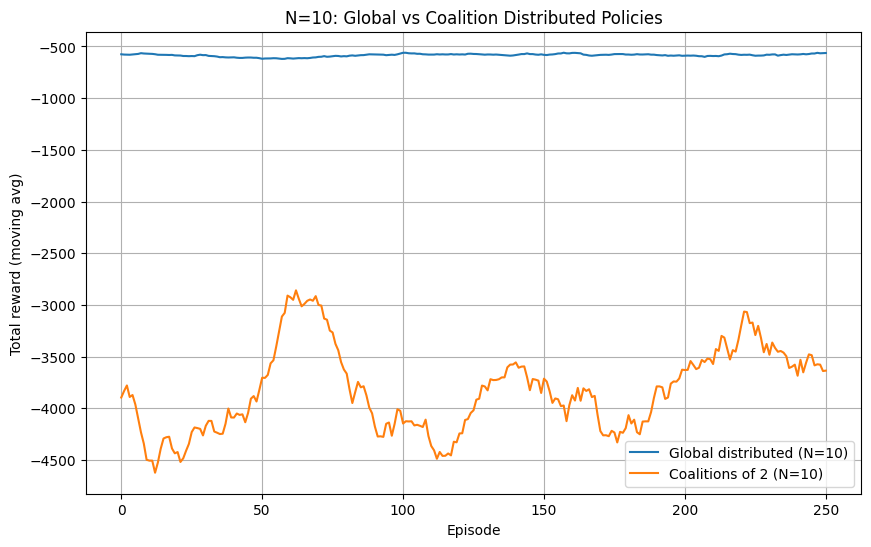

In [17]:
# -------------------------------------------------------
# N = 10 agents: global distributed policy vs 5 coalitions of 2
# -------------------------------------------------------

def direction_to_action(direction):
    """
    Helper: convert 2D direction vector to one of 5 discrete actions.
    0 = stay, 1 = left, 2 = right, 3 = up, 4 = down
    """
    dx, dy = direction

    if abs(dx) < 0.1 and abs(dy) < 0.1:
        return 0  # stay

    if abs(dx) > abs(dy):
        return 1 if dx < 0 else 2
    else:
        return 3 if dy > 0 else 4


def global_distributed_policy(observations):
    """
    All N agents share one global 'message' (average direction).
    """
    messages = []
    for obs in observations.values():
        direction = obs[:2]
        messages.append(direction)

    avg_direction = np.mean(messages, axis=0)
    action = direction_to_action(avg_direction)
    actions = {agent: action for agent in observations.keys()}
    return actions


# Define coalitions of 2 agents each for N=10
coalitions = [
    ["agent_0", "agent_1"],
    ["agent_2", "agent_3"],
    ["agent_4", "agent_5"],
    ["agent_6", "agent_7"],
    ["agent_8", "agent_9"],
]

def coalition_distributed_policy(observations, coalitions):
    """
    Each coalition shares its own averaged direction and takes a shared action.
    """
    actions = {}

    for group in coalitions:
        dirs = []
        for agent in group:
            obs = observations[agent]
            dirs.append(obs[:2])

        avg_direction = np.mean(dirs, axis=0)
        group_action = direction_to_action(avg_direction)

        for agent in group:
            actions[agent] = group_action

    return actions


def run_multiagent_policy(N, policy_fn, episodes=300, max_steps=30, coalitions=None):
    env = simple_spread_v3.parallel_env(
        N=N,
        local_ratio=0.5,
        max_cycles=max_steps,
        continuous_actions=False,
    )
    rewards = []
    total_steps = 0
    start = time.perf_counter()

    for ep in range(episodes):
        observations, _ = env.reset()
        ep_reward = 0

        for t in range(max_steps):
            if coalitions is None:
                actions = policy_fn(observations)
            else:
                actions = policy_fn(observations, coalitions)

            observations, r, terminated, truncated, infos = env.step(actions)
            ep_reward += sum(r.values())
            total_steps += 1

            if any(terminated.values()) or any(truncated.values()):
                break

        rewards.append(ep_reward)

    elapsed = time.perf_counter() - start
    latency = elapsed / max(total_steps, 1)
    return rewards, latency


episodes_10 = 300

# 7.6.1 – N=10 with global distributed policy
global_rewards_10, global_latency_10 = run_multiagent_policy(
    N=10,
    policy_fn=global_distributed_policy,
    episodes=episodes_10,
    max_steps=30,
    coalitions=None,
)

print("N=10 Global distributed policy:")
print(f"  Mean reward: {np.mean(global_rewards_10):.2f}")
print(f"  Latency per step: {global_latency_10:.6f} sec\n")

# 7.6.2 – N=10 with coalitions of 2
coalition_rewards_10, coalition_latency_10 = run_multiagent_policy(
    N=10,
    policy_fn=coalition_distributed_policy,
    episodes=episodes_10,
    max_steps=50,
    coalitions=coalitions,
)

print("N=10 Coalition policy (5 pairs of 2 agents):")
print(f"  Mean reward: {np.mean(coalition_rewards_10):.2f}")
print(f"  Latency per step: {coalition_latency_10:.6f} sec\n")


# Moving average helper for smoother plots
def moving_average(x, window=50):
    x = np.array(x)
    if len(x) < window:
        return x
    return np.convolve(x, np.ones(window) / window, mode="valid")

# Plot N=10 comparison
plt.figure(figsize=(10, 6))
plt.plot(moving_average(global_rewards_10, 50), label="Global distributed (N=10)")
plt.plot(moving_average(coalition_rewards_10, 50), label="Coalitions of 2 (N=10)")
plt.xlabel("Episode")
plt.ylabel("Total reward (moving avg)")
plt.title("N=10: Global vs Coalition Distributed Policies")
plt.grid(True)
plt.legend()
plt.show()


**3.4 – HLSCSN metrics plots (SAR, NE, TCR, alignment vs reward)**

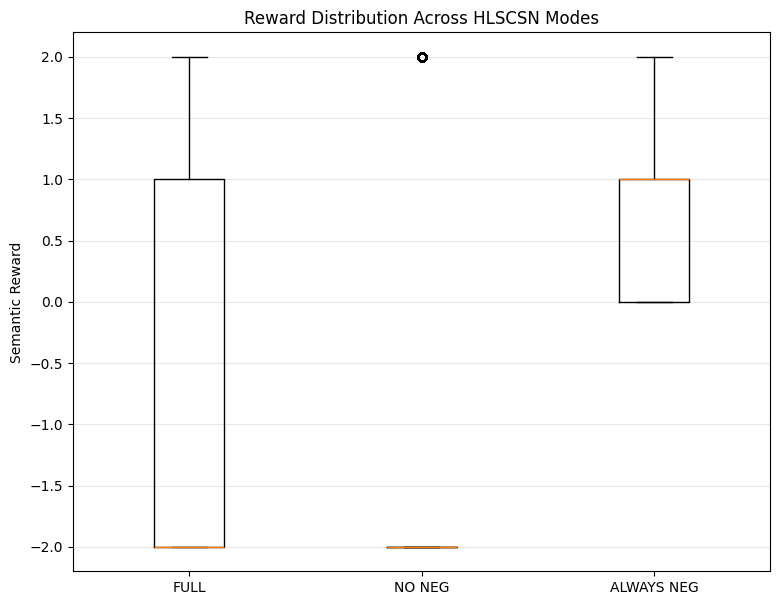

In [18]:
# -------------------------------------------------------
# 8.7 Plot HLSCSN metrics Alignment vs Reward
# -------------------------------------------------------

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Plot 1: Alignment vs Reward (scatter relationship)
plt.figure(figsize=(9,7))
plt.boxplot(
    [HLSCSN_rewards_full, HLSCSN_rewards_no_neg, HLSCSN_rewards_always_neg],
    labels=["FULL", "NO NEG", "ALWAYS NEG"]
)
plt.ylabel("Semantic Reward")
plt.title("Reward Distribution Across HLSCSN Modes")
plt.grid(True, axis='y', alpha=0.3)
plt.show()



**3.4 Combined SAR, NE, TCR Evolution Plot**

In [19]:
# ================================
# Utility: Moving average smoothing
# ================================
def smooth(x, window=100):
    """
    Simple moving average smoothing.
    Args:
        x (list or np.array): input signal
        window (int): smoothing window size
    Returns:
        np.array: smoothed signal
    """
    x = np.array(x)
    if len(x) < window:
        return x
    return np.convolve(x, np.ones(window) / window, mode="valid")


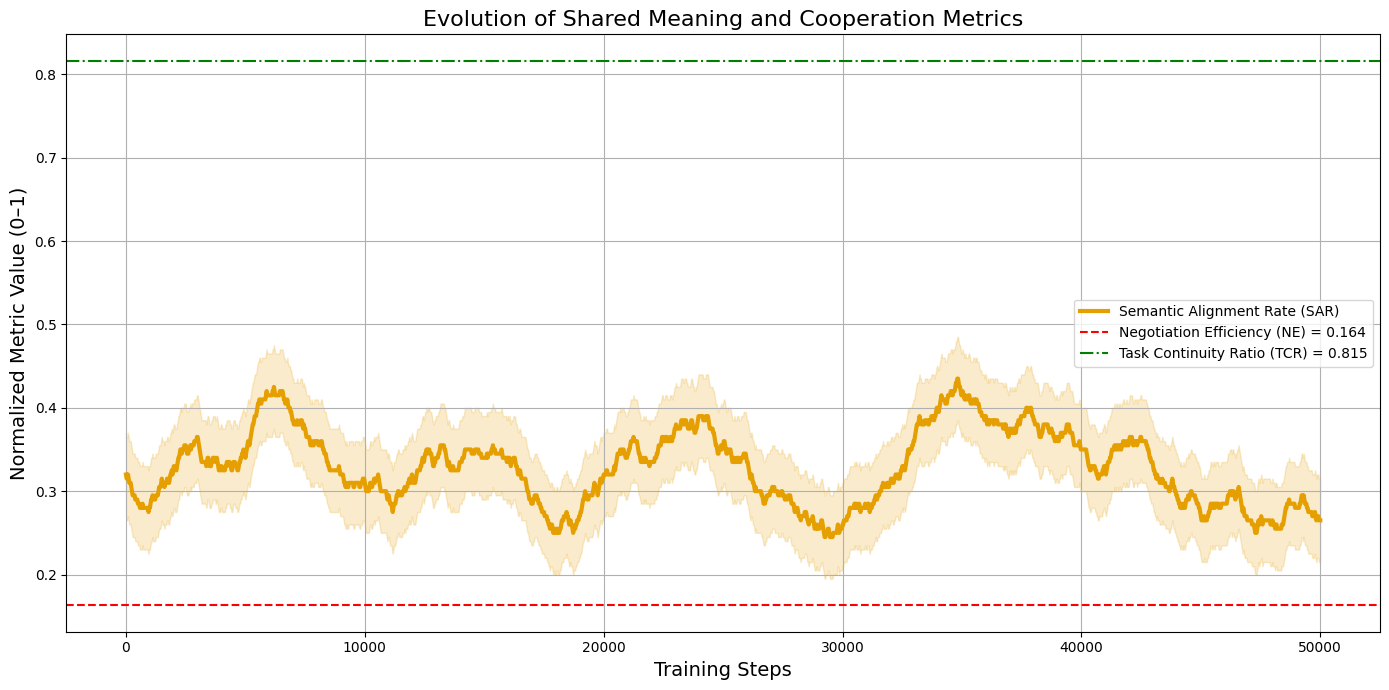


Average PPO episode reward: -49.68
PPO latency per step: 0.000958 sec
SAR=0.326, NE=0.164, TCR=0.815


In [20]:


# ================================
# Combined SAR, NE, TCR Evolution Plot (FINAL)
# ================================



# set x-axis scale to match PPO 50,000 training steps
total_steps = 50000

# --- Smooth SAR first (important: smoothing shortens the signal)
sar_smooth = smooth(SAR_list_full, window=200)

# --- Match x-axis length to smoothed signal
steps = np.linspace(0, total_steps, len(sar_smooth))

plt.figure(figsize=(14, 7))

# -------------------------------------------------
# Plot SAR (time-varying)
# -------------------------------------------------
plt.plot(
    steps,
    sar_smooth,
    color="#E69F00",
    linewidth=3,
    label="Semantic Alignment Rate (SAR)"
)

plt.fill_between(
    steps,
    sar_smooth - 0.05,
    sar_smooth + 0.05,
    color="#E69F00",
    alpha=0.2
)

# -------------------------------------------------
# NE horizontal reference line (mean)
# -------------------------------------------------
NE_mean = np.mean(NE_list_full)
plt.axhline(
    NE_mean,
    linestyle="--",
    color="red",
    label=f"Negotiation Efficiency (NE) = {NE_mean:.3f}"
)

# -------------------------------------------------
# TCR horizontal reference line (mean)
# -------------------------------------------------
TCR_mean = np.mean(TCR_list_full)
plt.axhline(
    TCR_mean,
    linestyle="-.",
    color="green",
    label=f"Task Continuity Ratio (TCR) = {TCR_mean:.3f}"
)

# -------------------------------------------------
# Plot formatting
# -------------------------------------------------
plt.title("Evolution of Shared Meaning and Cooperation Metrics", fontsize=16)
plt.xlabel("Training Steps", fontsize=14)
plt.ylabel("Normalized Metric Value (0–1)", fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Summary statistics (FIXED prints)
# -------------------------------------------------
print(f"\nAverage PPO episode reward: {np.mean(ppo_rewards):.2f}")
print(f"PPO latency per step: {ppo_latency:.6f} sec")
print(
    f"SAR={np.mean(SAR_list_full):.3f}, "
    f"NE={NE_mean:.3f}, "
    f"TCR={TCR_mean:.3f}"
)


**PLOTS FOR HLSCSN ABLATION**

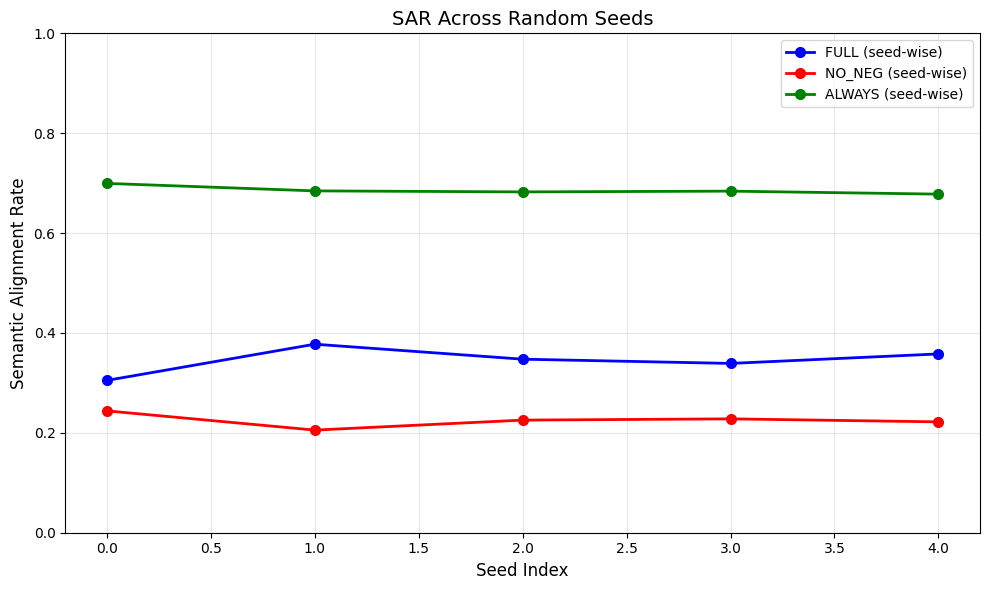

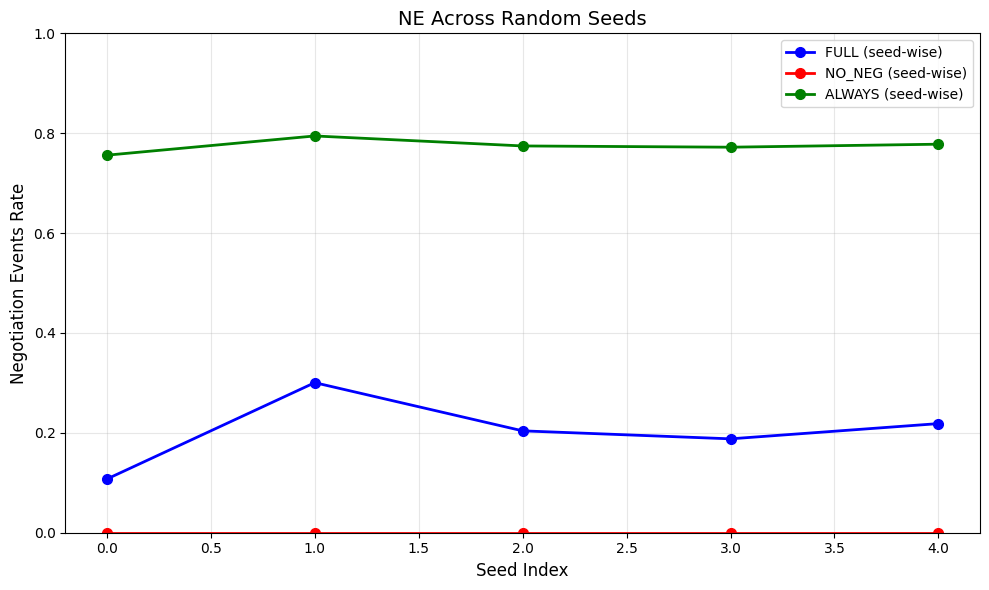

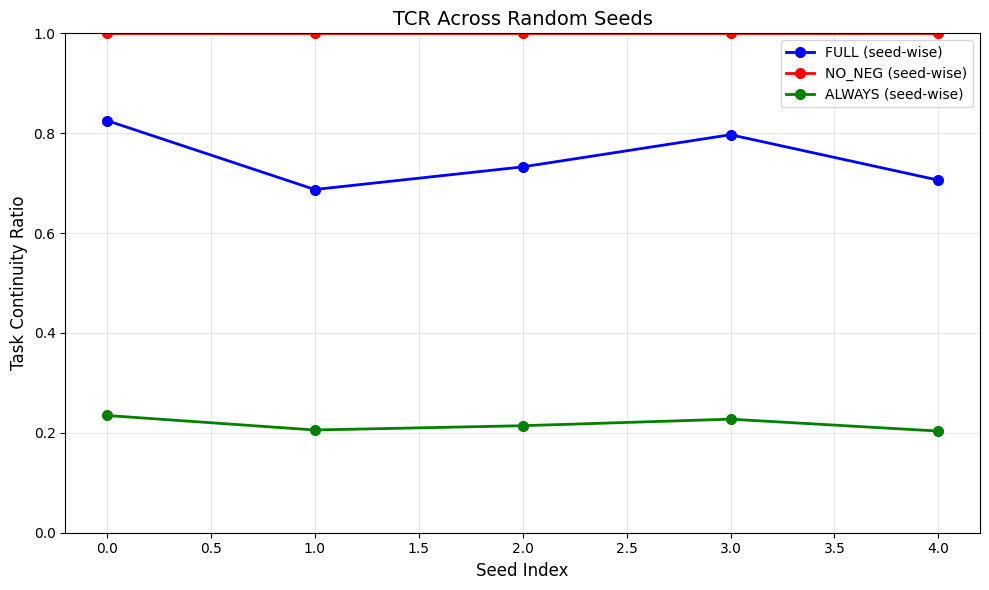

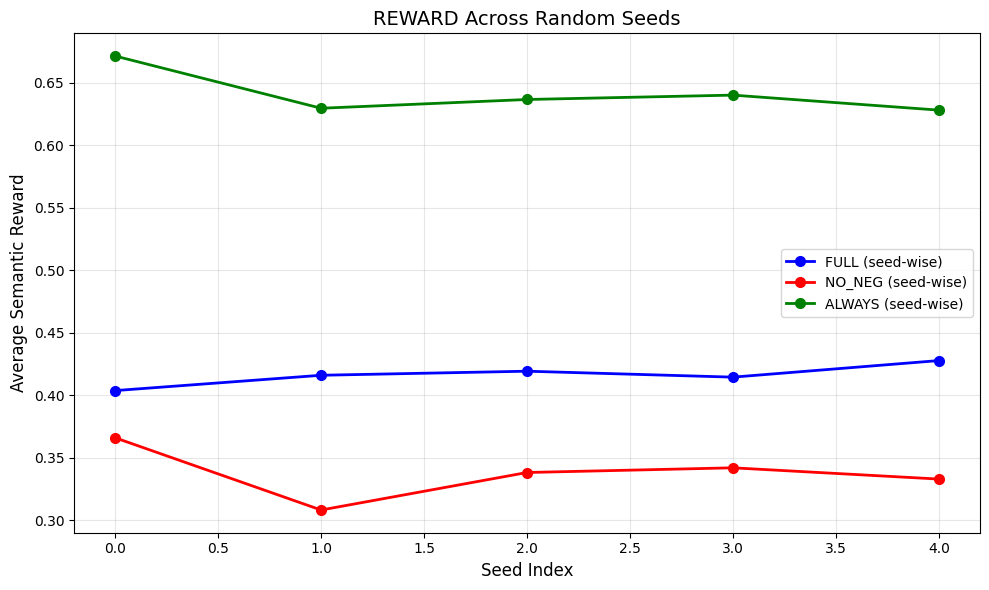

In [21]:
# ===============================================================
# STEP 5A – RESEARCH-LEVEL PLOTS FOR HLSCSN ABLATION (FINAL)
# ===============================================================

import matplotlib.pyplot as plt

modes = ["full", "no_neg", "always"]

colors = {
    "full": "blue",
    "no_neg": "red",
    "always": "green"
}

def plot_metric(metric_name, ylabel, ylim=None, save=True):
    """
    Plot a given metric across random seeds for all HLSCSN modes.
    This function is fully data-driven (no hard-coded values).
    """
    plt.figure(figsize=(10, 6))

    for mode in modes:
        data = results[mode][metric_name]  # pulled directly from experiments
        plt.plot(
            data,
            marker="o",
            linewidth=2,
            markersize=7,
            label=f"{mode.upper()} (seed-wise)",
            color=colors[mode]
        )

    plt.title(f"{metric_name.upper()} Across Random Seeds", fontsize=14)
    plt.xlabel("Seed Index", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    if ylim is not None:
        plt.ylim(ylim)

    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    if save:
        plt.savefig(
            f"{metric_name}_across_seeds.png",
            dpi=300,
            bbox_inches="tight"
        )

    plt.show()


# ---------------------------------------------------------------
# Generate all ablation plots (data-driven)
# ---------------------------------------------------------------

# Semantic Alignment Rate
plot_metric(
    metric_name="SAR",
    ylabel="Semantic Alignment Rate",
    ylim=(0, 1)
)

# Negotiation Events Rate
plot_metric(
    metric_name="NE",
    ylabel="Negotiation Events Rate",
    ylim=(0, 1)
)

# Task Continuity Ratio
plot_metric(
    metric_name="TCR",
    ylabel="Task Continuity Ratio",
    ylim=(0, 1)
)

# Reward (do NOT clamp reward axis)
plot_metric(
    metric_name="reward",
    ylabel="Average Semantic Reward",
    ylim=None
)


**Ablation Curves (Main Result)**

Across all seeds, ALWAYS negotiation achieves the highest semantic alignment but incurs excessive communication, sharply reducing task continuity. NO_NEG maximizes efficiency yet consistently fails to resolve semantic mismatches. The FULL HLSCSN policy adaptively negotiates, achieving a robust balance between alignment and efficiency, which explains its stable performance across metrics.

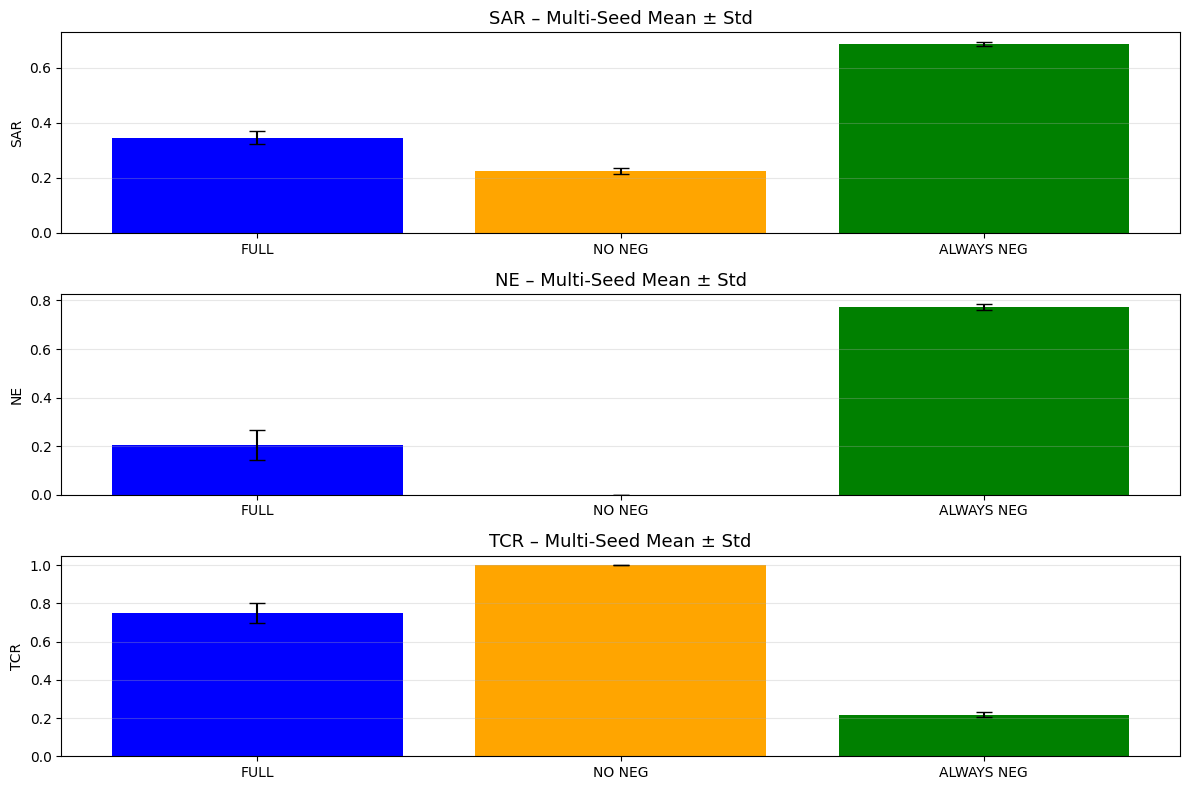

In [22]:
# ===============================================================
# FIGURE 2 – MULTI-SEED METRICS (MEAN ± STD)
# ===============================================================

modes_display = ["FULL", "NO NEG", "ALWAYS NEG"]
modes_keys = ["full", "no_neg", "always"]

metrics = ["SAR", "NE", "TCR"]
colors = ["blue", "orange", "green"]

plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics):
    plt.subplot(3, 1, i+1)

    means = [np.mean(results[m][metric]) for m in modes_keys]
    stds  = [np.std(results[m][metric])  for m in modes_keys]

    plt.bar(modes_display, means, yerr=stds, capsize=6, color=colors)
    plt.title(f"{metric} – Multi-Seed Mean ± Std", fontsize=13)
    plt.ylabel(metric)
    plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


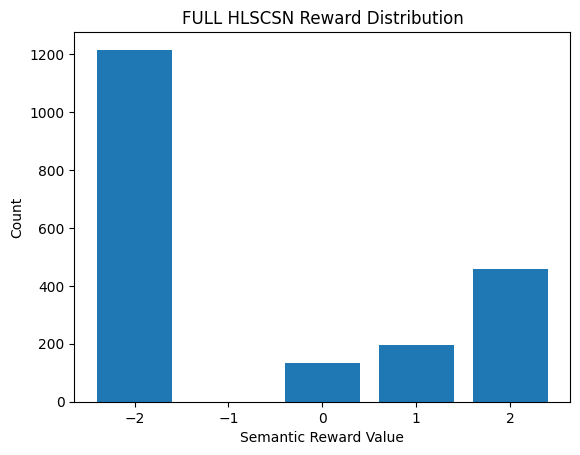

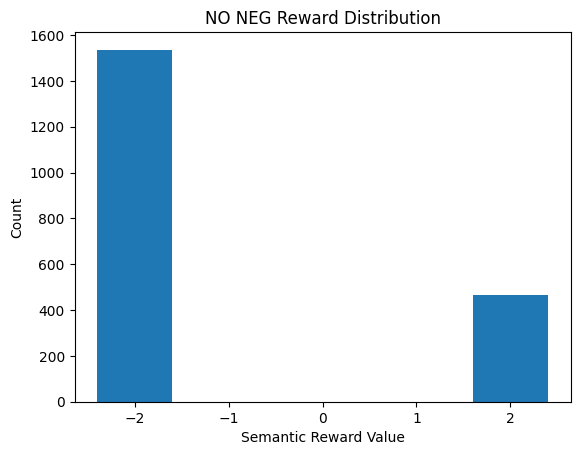

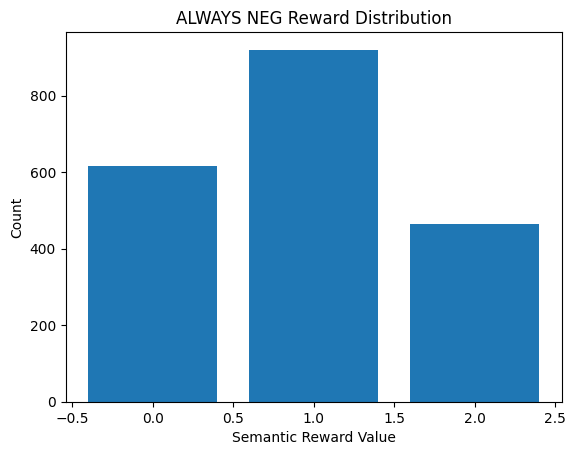

In [23]:
import collections
import matplotlib.pyplot as plt

def plot_reward_histogram(rewards, title):
    counter = collections.Counter(rewards)
    xs = sorted(counter.keys())
    ys = [counter[x] for x in xs]

    plt.bar(xs, ys)
    plt.xlabel("Semantic Reward Value")
    plt.ylabel("Count")
    plt.title(title)
    plt.show()

plot_reward_histogram(HLSCSN_rewards_full, "FULL HLSCSN Reward Distribution")
plot_reward_histogram(HLSCSN_rewards_no_neg, "NO NEG Reward Distribution")
plot_reward_histogram(HLSCSN_rewards_always_neg, "ALWAYS NEG Reward Distribution")


(let-exp (ids rands body)
  (let ((args (eval-rands rends env)))
  (eval-expression body (extend-env ids args env))))